# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create the ion channel model

In [7]:
from channels.iha import iha as model
#model.sample({})

# Get experimental measurements

In [8]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [9]:
limits = dict(g_ha=(0, 0.2),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 1),
              p4=(-100, 100),
              p5=(0, 100),
              p6=(0, 1),
              p7=(0, 200),
              p8=(-100, 0),
              k_i_haNa=(0, 1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['iha.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

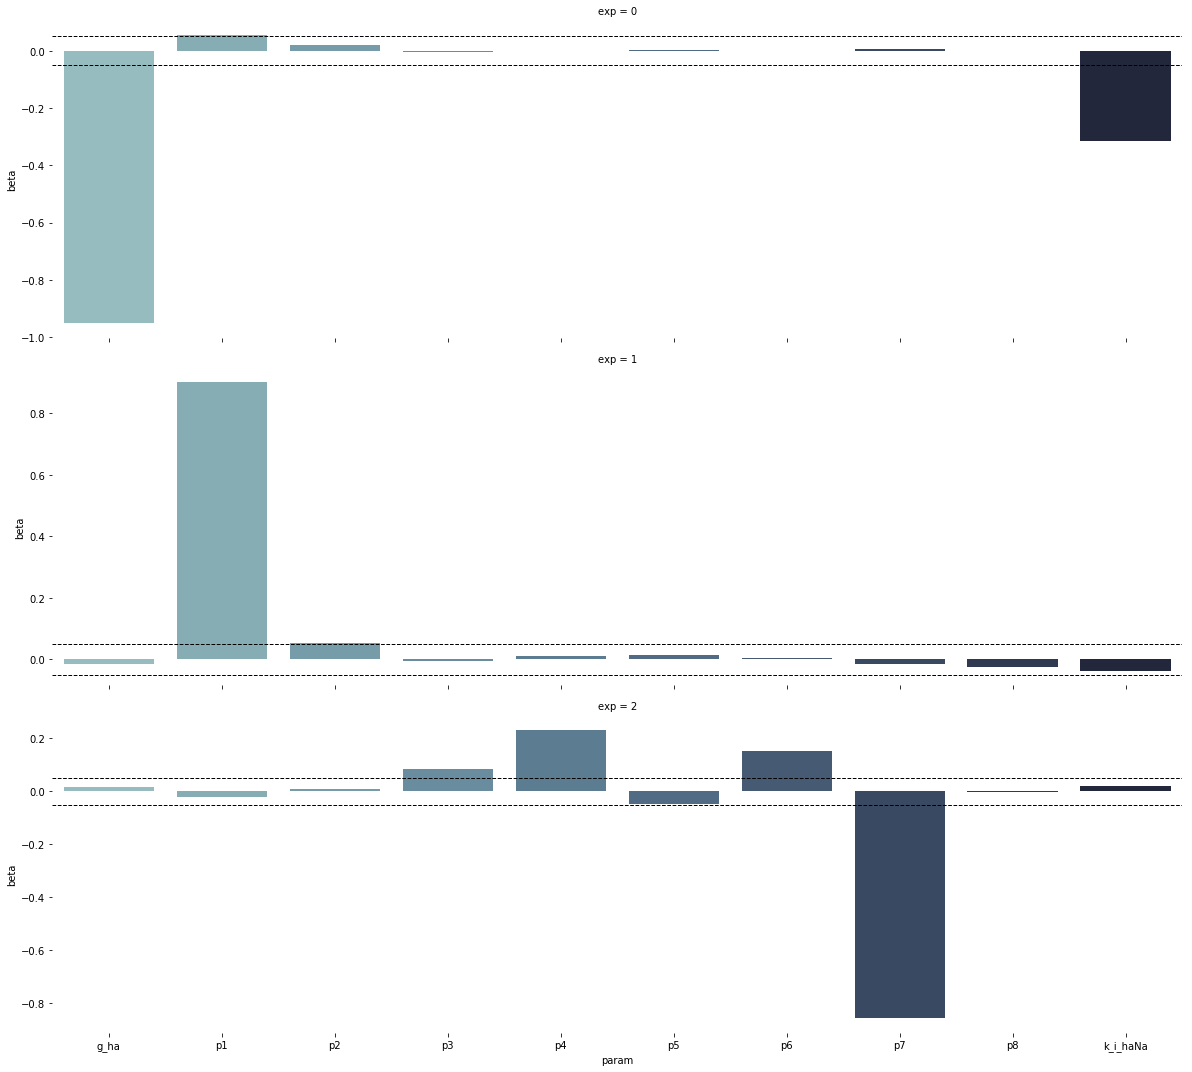

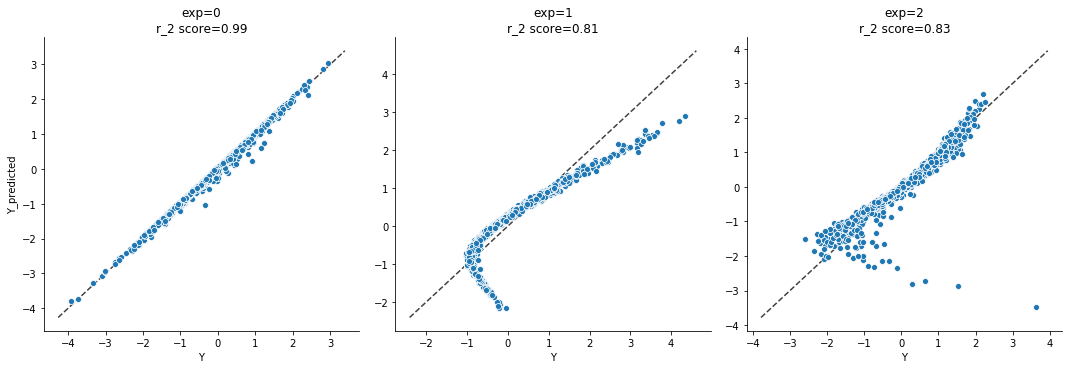

In [10]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [11]:
grid1.savefig('results/iha/sensitivity.pdf')
grid2.savefig('results/iha/sensitivity_fit.pdf')

In [27]:
limits = dict(g_ha=(0, 0.2),
              p1=(0, 100),
              p3=(0, 1),
              p4=(-200, 100),
              p5=(0, 100),
              p6=(0, 1),
              p7=(0, 200),
              k_i_haNa=(0, 1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise database

In [82]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_iha5000.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_iha5000.db


In [83]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [84]:
from pyabc.populationstrategy import ConstantPopulationSize

In [85]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(
                 nr_particles=5000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=5000,
             #    mean_cv=0.2,
             #    max_population_size=5000,
             #    min_population_size=2500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.23291016577034931, 1: 0.32545103225145916, 2: 0.4167902903278747, 3: 0.44824616129601674, 4: 0.5939261637172222, 5: 0.5939261637172222, 6: 0.6788076721341819, 7: 0.7233305530634934, 8: 0.7233305530634934, 9: 0.7233305530634934, 10: 0.7233305530634934, 11: 0.7233305530634934, 12: 0.7233305530634934, 13: 0.7233305530634934, 14: 0.7233305530634934, 15: 1.7185479328719149, 16: 1.7185479328719149, 17: 1.7185479328719149, 18: 1.7185479328719149, 19: 1.7185479328719149, 20: 1.7185479328719149, 21: 1.7185479328719149, 22: 1.7185479328719149, 23: 1.248162135043625, 24: 1.248162135043625, 25: 1.248162135043625, 26: 1.248162135043625, 27: 1.248162135043625, 28: 0.932608949870775, 29: 0.5934784226450392, 30: 0.40801641556846413}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [86]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-11-14 09:21:36.159763, end_time=None)>
INFO:Epsilon:initial epsilon is 10.60961681746209


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:10.60961681746209
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 9788
DEBUG:Epsilon:new eps, t=1, eps=6.040673747494243
INFO:ABC:t:1 eps:6.040673747494243
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 20407
DEBUG:Epsilon:new eps, t=2, eps=4.983022739599614
INFO:ABC:t:2 eps:4.983022739599614
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 31815
DEBUG:Epsilon:new eps, t=3, eps=4.444833884037954
INFO:ABC:t:3 eps:4.444833884037954
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 44122
DEBUG:Epsilon:new eps, t=4, eps=3.99633038164439
INFO:ABC:t:4 eps:3.99633038164439
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 57491
DEBUG:Epsilon:new eps, t=5, eps=3.6796

# Results analysis

In [88]:
history = [History('sqlite:////scratch/cph211/tmp/hl-1_iha50.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha100.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha500.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha750.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha1000.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha2000.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha3000.db'),
           History('sqlite:////scratch/cph211/tmp/hl-1_iha5000.db')]
particle_num = [50,100,500,750,1000,2000,3000,5000]

In [89]:
n_samples=5000
th_samples = pd.DataFrame({})
for h, p in zip(history, particle_num):
    df, w = h.get_distribution(m=0)
    th = pd.DataFrame(df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records'))
    th['particle_num'] = p
    th_samples = th_samples.append(th)

In [90]:
th_samples = th_samples.melt(value_vars=th_samples.columns[:-1], id_vars=['particle_num'])

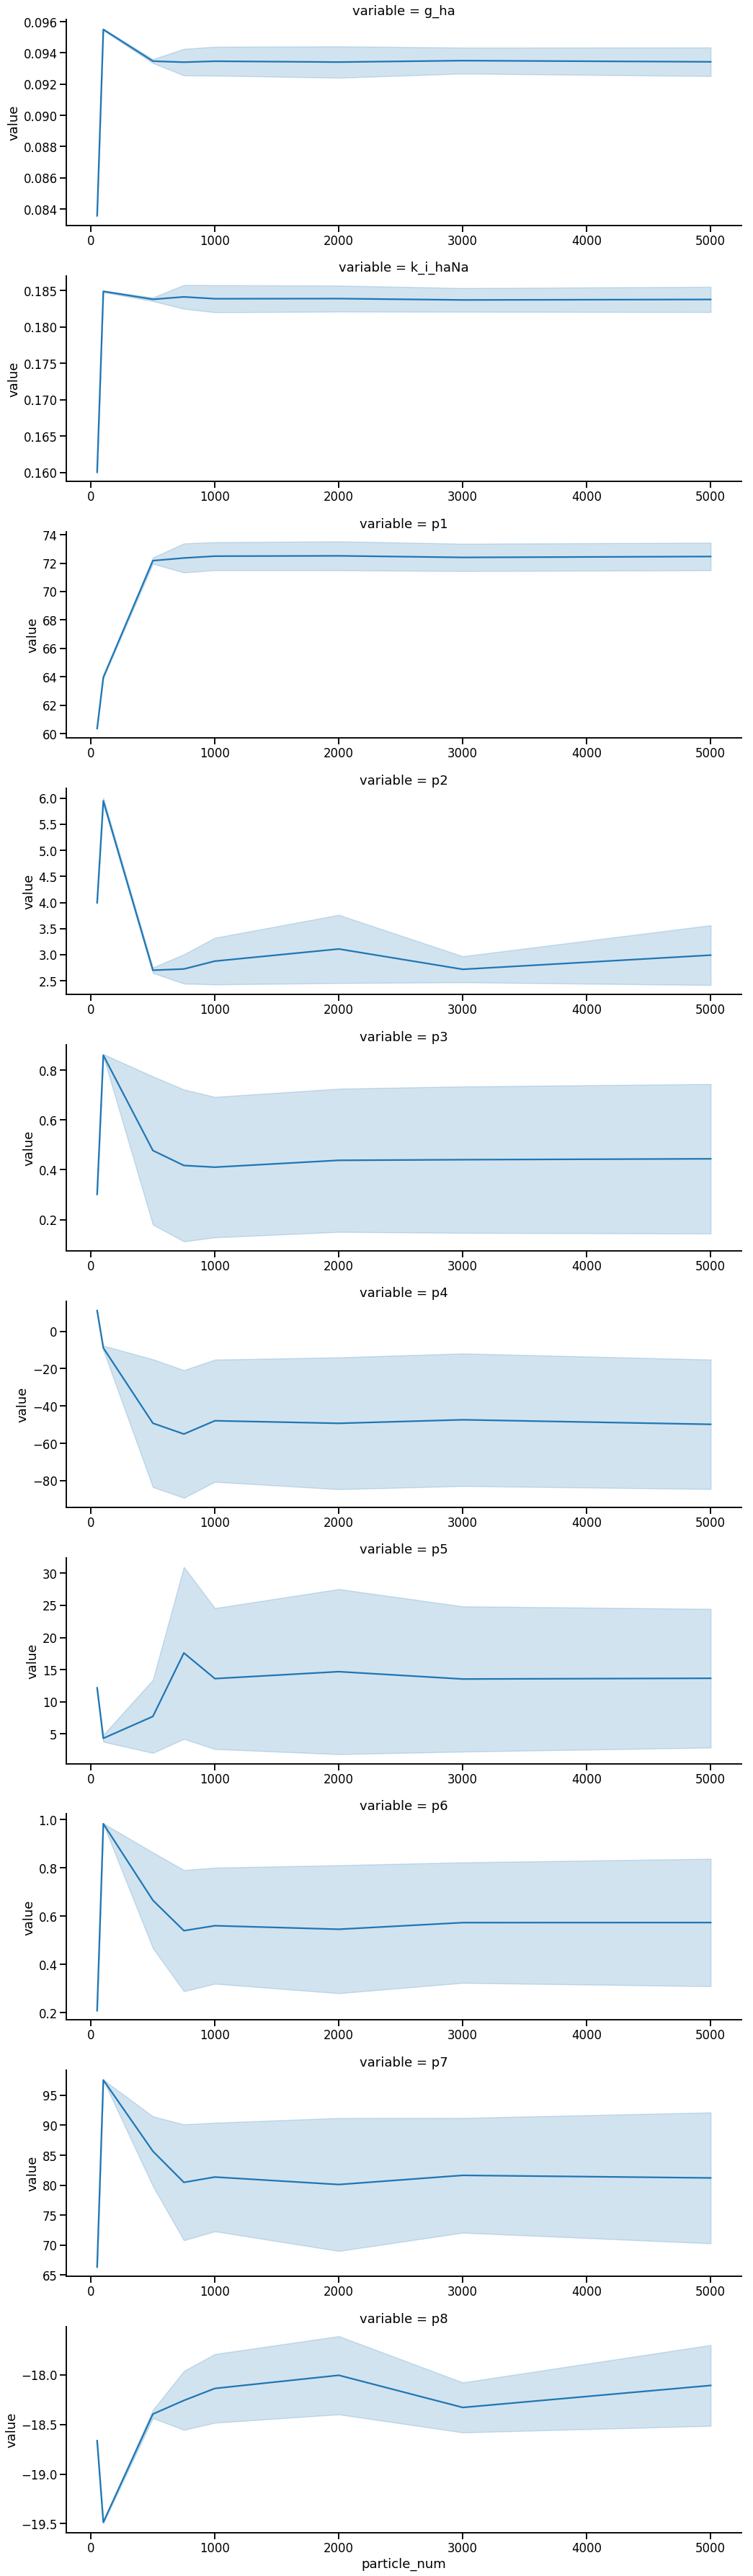

In [98]:
sns.set_context('talk')
grid = sns.relplot(x='particle_num',y='value',row='variable',data=th_samples,
                   kind='line',n_boot=5000,ci='sd',aspect=3,
                   facet_kws={'sharex': 'row',
                              'sharey': False})

In [99]:
grid.savefig('results/convergence/iha/iha_convergence.pdf')